# Solar Credit PayGo Repayment Default

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.metrics import mean_squared_error as mse , r2_score
import warnings
warnings.filterwarnings('ignore')
import re

## Working Functions

In [16]:
train = pd.read_csv('Train.csv')
#train.head()
metadata = pd.read_csv('metadata.csv')
#metadata.head()

metadata[['RegistrationDate','ExpectedTermDate','FirstPaymentDate','LastPaymentDate']] = metadata[['RegistrationDate','ExpectedTermDate','FirstPaymentDate','LastPaymentDate']].apply(
    lambda x:pd.to_datetime(x, format='%d/%m/%Y %H:%M') )
metadata['expected_installments'] = (metadata['ExpectedTermDate'] - metadata['RegistrationDate']).apply(lambda x:int(x.days/30) )
metadata_col_drop =['PaymentMethod','SupplierName','UpsellDate','AccessoryRate','Town',
               'RegistrationDate','ExpectedTermDate','FirstPaymentDate','LastPaymentDate']
metadata = metadata.drop(metadata_col_drop,axis=1)


def age_grouper(x):
        if x<30:
            return '<31'
        elif x<50:
            return '31-60'
        elif x>60:
            return '>60'
        else:
            return 'other' #not given or missing
        

def create_dict_converter(df):#train_data
    # Get dictionaries for labels
    for i in df.columns:
        if df[i].dtype == 'object' and i!= 'ID' :
            new_dict = dict()
            for j,unique_value in enumerate(df[i].unique()):
                new_dict[unique_value] = j
            name_ = 'dict_'+str(i) 
            globals()[name_]=new_dict

def SD_mean(x):
    if x[3]>0:
        return x[2]- (x[1]-x[0])/x[3]
    else:
        return 0
            
            
def unda_df(df):#train
    df['mean_payment'] = df['PaymentsHistory'].apply(lambda x:np.mean(list(map(float, x.strip('[]').split(','))) ))
    df['max_payment'] = df['PaymentsHistory'].apply(lambda x:np.max(list(map(float, x.strip('[]').split(','))) ))
    df['min_payment'] = df['PaymentsHistory'].apply(lambda x:np.min(list(map(float, x.strip('[]').split(','))) ))
    df['amount_paid_so_far'] = df['PaymentsHistory'].apply(lambda x:np.sum(list(map(float, x.strip('[]').split(','))) ))
    
    all_dates = [date_ for date_list in df["TransactionDates"] for date_ in re.findall("[^,\[ \]'']+",date_list)]
    all_dates = pd.PeriodIndex(pd.Series(all_dates).value_counts().index.values, freq='M',).sort_values().astype(str)
    all_dates = pd.Series(all_dates).apply(lambda x:str(x)[-2:]+'-'+str(x)[:-3])
    transaction_dict = dict()
    for i in all_dates:
        transaction_dict[i]=[]

    for date_s,transaction_l in zip(df["TransactionDates"],df["PaymentsHistory"]):
        date_l = re.findall("[^,\[ \]'']+",date_s)
        transaction = re.findall("[^,\[ \]'']+",transaction_l)
        for transaction_s,date_s in zip(transaction,date_l):
            transaction_dict[date_s].append(transaction_s)
        no_transaction = [da_te for da_te in transaction_dict.keys() if da_te not in date_l]
        for j in no_transaction: # fill zero for month with no transaction
            transaction_dict[j].append(0.0)

    Transaction_df = pd.DataFrame(transaction_dict).astype(float)
    Transaction_df['ID'] = df.ID 
    df = df.drop(['PaymentsHistory','TransactionDates'],axis=1)
    df_data = pd.merge(metadata,df , how ='inner', on='ID')
    df_data = pd.merge(df_data,Transaction_df , how ='inner', on='ID')
    df_data['Deviation_from_expe_inst'] = df_data[['Deposit','TotalContractValue','mean_payment','expected_installments']].apply(SD_mean,axis=1)
    df_data['Region'] = df_data['Region'].fillna('Not Given')
    df_data['Age'] = df_data['Age'].apply(age_grouper)
    return df_data

    
def unda_df_2(df_data):
    for i in df_data.columns:
        if df_data[i].dtype == 'object' and i!= 'ID' :
            df_data[i] = df_data[i].astype("category")
            df_data[i] = df_data[i].apply(lambda x:globals()['dict_'+str(i)][x])
    
    df_data = df_data.set_index('ID')
    df_data['max_mean_diff'] = df_data['max_payment']-df_data['mean_payment'] 
    df_data['min_mean_diff'] = df_data['mean_payment']-df_data['min_payment'] 
    df_data['amount_left'] = df_data['TotalContractValue']-df_data['Deposit']-df_data['amount_paid_so_far']

    cols_to_drop = []
    for i in df_data.columns:
        m_vals,n_counts = np.unique(df_data[i], return_counts=True)
        freqmax_val,max_count = m_vals[n_counts.argmax()], n_counts.max()

        if freqmax_val == 0.0 and max_count>len(df_data)*0.88:
            cols_to_drop.append(i)
    
    df_data_reduced = df_data.drop(cols_to_drop+['rateTypeEntity','RatePerUnit','DaysOnDeposit','Deposit'],
                                   errors='ignore', axis=1)
    return df_data_reduced

def train_data_only(df_data_reduced):
    df_data_reduced_ = df_data_reduced[[i for i in df_data_reduced.columns 
                                        if i not in ['m1','m2','m3','m4','m5','m6']]]
    df_data_reduced_[['m1','m2','m3','m4','m5','m6']] = df_data_reduced[['m1','m2','m3','m4','m5','m6']]    
    return df_data_reduced_

In [17]:
train_data = unda_df(train)
create_dict_converter(train_data)
train_data_reduced_ = unda_df_2(train_data)
train_data_reduced = train_data_only(train_data_reduced_)

In [18]:
train_data_reduced.shape

(28007, 61)

### Baseline Model

In [36]:
training_data,testing_data = train_test_split(train_data_reduced, test_size= 0.2, random_state=12)

percentiles_f = np.percentile( training_data[['m1','m2','m3','m4','m5','m6']] ,99.5,axis=0 )
selection_m = training_data[['m1','m2','m3','m4','m5','m6']]<percentiles_f #== True
trainded = training_data[selection_m.apply(lambda x:all(x==True),axis=1)]

train_x = trainded[[i for i in trainded.columns if i not in ['m1','m2','m3','m4','m5','m6']]]
train_y = trainded[['m1','m2','m3','m4','m5','m6']]
test_x = testing_data [[i for i in trainded.columns if i not in ['m1','m2','m3','m4','m5','m6']]]
test_y = testing_data [['m1','m2','m3','m4','m5','m6']]


base_model = RFR()
base_model.fit(train_x,train_y)
model_result = base_model.predict(test_x)
print('MSE : ',mse(model_result,test_y),'\nRMSE : ',mse(model_result,test_y,squared=False))

#plt.figure(figsize=(10,10))
#plt.barh(train_x.columns,model.feature_importances_ )

MSE :  422578.662273191 
RMSE :  583.5869063415917


<BarContainer object of 55 artists>

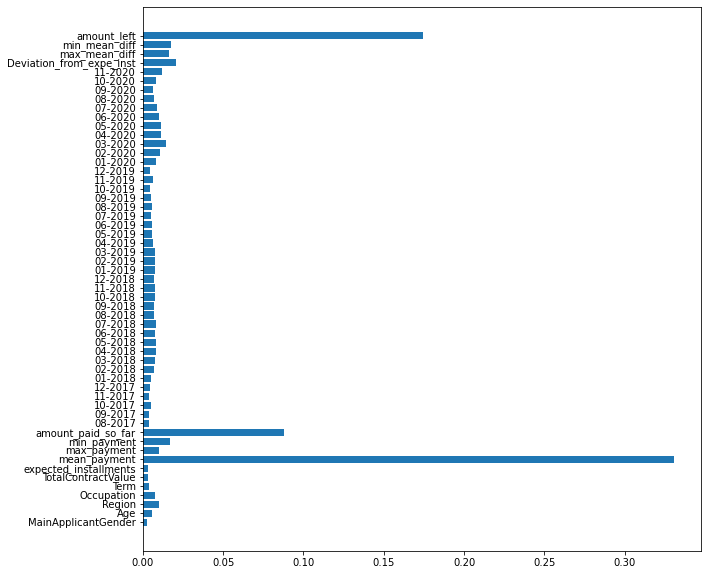

In [31]:
plt.figure(figsize=(10,10))
plt.barh(train_x.columns,base_model.feature_importances_ )

### MODEL

In [38]:
#percentiles_f = np.percentile( train_data_reduced[['m1','m2','m3','m4','m5','m6']] ,99.5,axis=0 )
#selection_m = train_data_reduced[['m1','m2','m3','m4','m5','m6']]<percentiles_f #== True
#trainded = train_data_reduced[selection_m.apply(lambda x:all(x==True),axis=1)]
#x = trainded[[i for i in train_data_reduced.columns if i not in ['m1','m2','m3','m4','m5','m6']]]
#y = trainded[['m1','m2','m3','m4','m5','m6']]
#train_x,test_x,train_y,test_y = train_test_split(x,y,test_size= 0.2, random_state=12)

training_data,testing_data = train_test_split(train_data_reduced, test_size= 0.2, random_state=12)
percentiles_f = np.percentile( training_data[['m1','m2','m3','m4','m5','m6']] ,99.5,axis=0 )
selection_m = training_data[['m1','m2','m3','m4','m5','m6']]<percentiles_f #== True
trainded = training_data[selection_m.apply(lambda x:all(x==True),axis=1)]
train_x = trainded[[i for i in trainded.columns if i not in ['m1','m2','m3','m4','m5','m6']]]
train_y = trainded[['m1','m2','m3','m4','m5','m6']]
test_x = testing_data [[i for i in trainded.columns if i not in ['m1','m2','m3','m4','m5','m6']]]
test_y = testing_data [['m1','m2','m3','m4','m5','m6']]

model = RFR(n_estimators= 700, max_depth=12, min_samples_split=10, max_features=0.7) 
model.fit(train_x, train_y)
model_result = model.predict(test_x)
print('MSE : ',mse(model_result,test_y),'\nRMSE : ',mse(model_result,test_y,squared=False))
#plt.figure(figsize=(10,10))
#plt.barh(train_x.columns,model.feature_importances_ )


MSE :  420181.29625104653 
RMSE :  581.0382289512232


<BarContainer object of 55 artists>

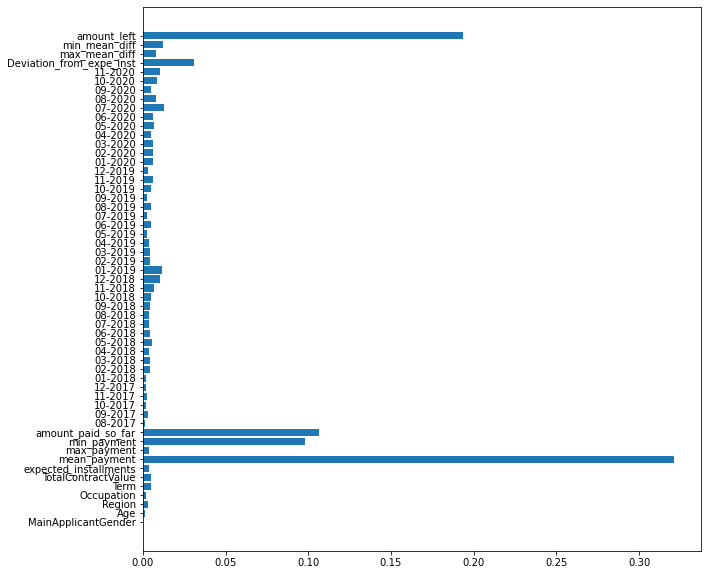

In [24]:
plt.figure(figsize=(10,10))
plt.barh(train_x.columns,model.feature_importances_ )

In [25]:
print("M1 : ",mse(model_result[:,0],test_y.iloc[:,0].values,squared=False) , r2_score(model_result[:,0],test_y.iloc[:,0].values) )
print("M2 : ",mse(model_result[:,1],test_y.iloc[:,1].values,squared=False) , r2_score(model_result[:,1],test_y.iloc[:,1].values) )
print("M3 : ",mse(model_result[:,2],test_y.iloc[:,2].values,squared=False) , r2_score(model_result[:,2],test_y.iloc[:,2].values) )
print("M4 : ",mse(model_result[:,3],test_y.iloc[:,3].values,squared=False) , r2_score(model_result[:,3],test_y.iloc[:,3].values) )
print("M5 : ",mse(model_result[:,4],test_y.iloc[:,4].values,squared=False) , r2_score(model_result[:,4],test_y.iloc[:,4].values) )
print("M6 : ",mse(model_result[:,5],test_y.iloc[:,5].values,squared=False) , r2_score(model_result[:,5],test_y.iloc[:,5].values) )

M1 :  332.7402548037712 0.446660211423033
M2 :  353.5564661351162 0.3964220484008404
M3 :  350.5770806734049 0.4261298217240189
M4 :  372.67469591356814 0.3346805575070617
M5 :  380.6070921414394 0.29882845516121537
M6 :  563.65029324835 -1.0382618806799626


In [26]:
print("Standard Deviations")
print( " M1 : ",test_y.iloc[:,0].std(),"\tPred std : ",model_result[:,0].std() )
print( " M2 : ",test_y.iloc[:,1].std(),"\tPred std : ",model_result[:,1].std() )
print( " M3 : ",test_y.iloc[:,2].std(),"\tPred std : ",model_result[:,2].std() )
print( " M4 : ",test_y.iloc[:,3].std(),"\tPred std : ",model_result[:,3].std() )
print( " M5 : ",test_y.iloc[:,4].std(),"\tPred std : ",model_result[:,4].std() )
print( " M6 : ",test_y.iloc[:,5].std(),"\tPred std : ",model_result[:,0].std() )

Standard Deviations
 M1 :  568.5554205866526 	Pred std :  447.3108112371351
 M2 :  580.0891686369102 	Pred std :  455.0845598514107
 M3 :  590.8066706073976 	Pred std :  462.7822485140932
 M4 :  595.3970022082203 	Pred std :  456.8933092682413
 M5 :  593.2278381758342 	Pred std :  454.5322837768939
 M6 :  680.2517515550006 	Pred std :  447.3108112371351


In [27]:
test  = pd.read_csv("Test.csv")
test_data = unda_df(test)
test_data_reduced_ = unda_df_2(test_data)
model_result = model.predict(test_data_reduced_)
model_result_df=pd.DataFrame(model_result,index=test_data_reduced_.index, columns=['m1','m2','m3','m4','m5','m6'])
model_result_df = model_result_df.stack().reset_index()
model_result_df['ID']= model_result_df[['ID','level_1']].agg(' x '.join, axis=1)
model_result_df = model_result_df.drop('level_1',axis=1).rename(columns={0:'Target'}).set_index('ID')
model_result_df.to_csv("SubmissionDateColumns.csv")
model_result_df.head()


,Target
ID,
ID_6L67PAA x m1,1048.622246
ID_6L67PAA x m2,1123.390310
ID_6L67PAA x m3,1079.796107
ID_6L67PAA x m4,1086.433690
ID_6L67PAA x m5,1087.980280


In [13]:
model_result_df.head()

,Target
ID,
ID_6L67PAA x m1,1070.898034
ID_6L67PAA x m2,1110.187087
ID_6L67PAA x m3,1109.479907
ID_6L67PAA x m4,1102.393687
ID_6L67PAA x m5,1104.067719
